# Convolutional Neural Networks

## The Architecture of the Visual Cortex

## Convolutional Layer

- 图片导入

In [5]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

image = china[150:220, 120:250]

height, width, channels = image.shape

image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

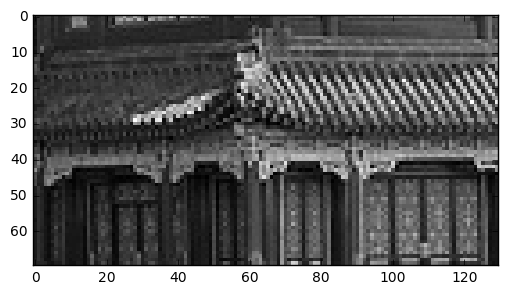

In [21]:
plt.imshow(images[0, :, :, 0], cmap="gray", interpolation="nearest")
plt.show()

In [13]:
china.shape

(427, 640, 3)

In [14]:
image.shape

(70, 130, 3)

In [15]:
image_grayscale.shape

(70, 130)

- 卷积

In [16]:
tf.reset_default_graph()

In [18]:
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X:images})

In [19]:
output.shape

(1, 70, 130, 2)

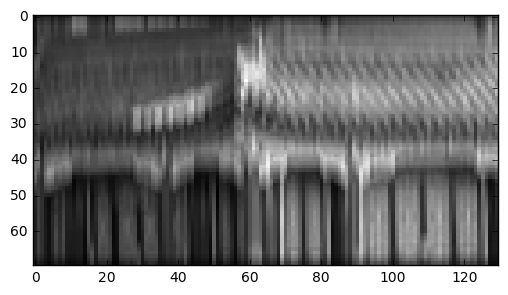

In [22]:
plt.imshow(output[0, :, :, 0], cmap="gray", interpolation="nearest")
plt.show()

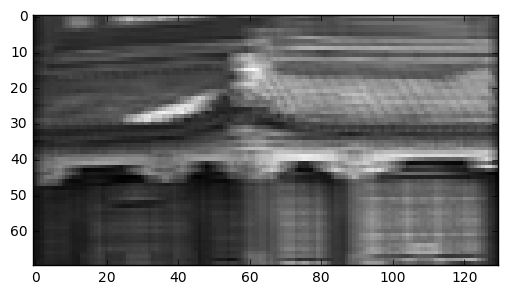

In [23]:
plt.imshow(output[0, :, :, 1], cmap="gray", interpolation="nearest")
plt.show()

In [25]:
dataset = np.array([china, flower], dtype=np.float32)
dataset.shape

(2, 427, 640, 3)

In [26]:
batch_size, height, width, channels = dataset.shape

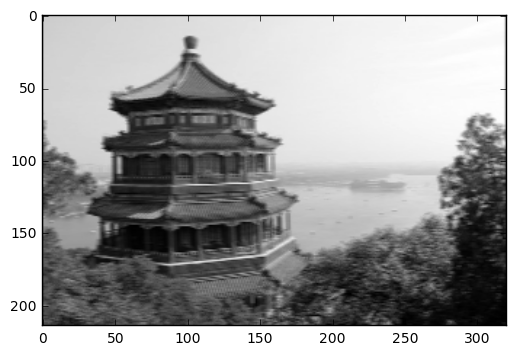

In [27]:
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0]=1
filters[3,:,:,1]=1

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:dataset})
    
plt.imshow(output[0,:,:,1],cmap="gray")
plt.show()

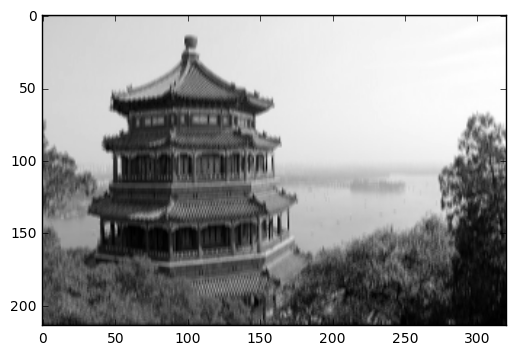

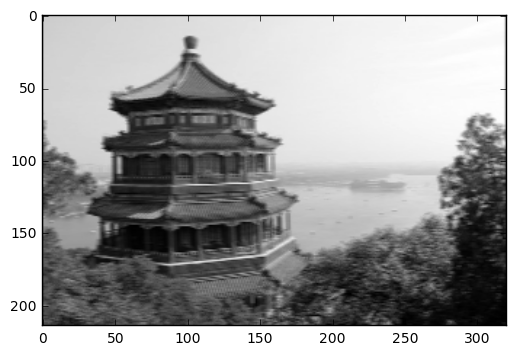

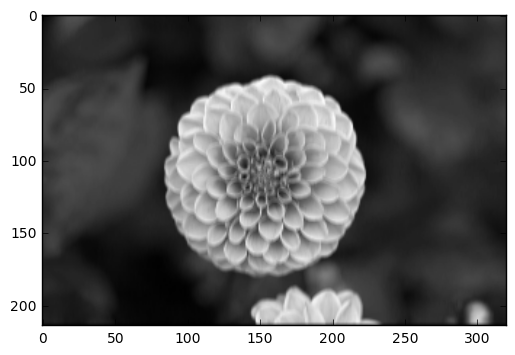

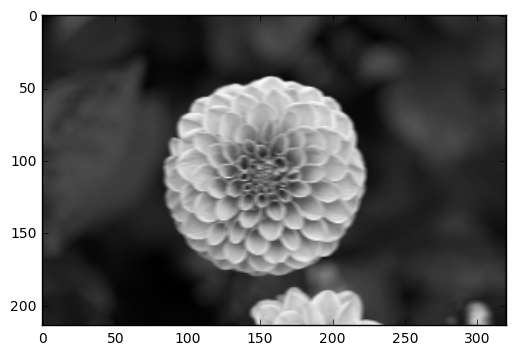

In [29]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.imshow(output[image_index, :, :, feature_map_index], cmap="gray")
        plt.show()

- VALID 与 SAME padding

In [30]:
filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


## Pooling Layer

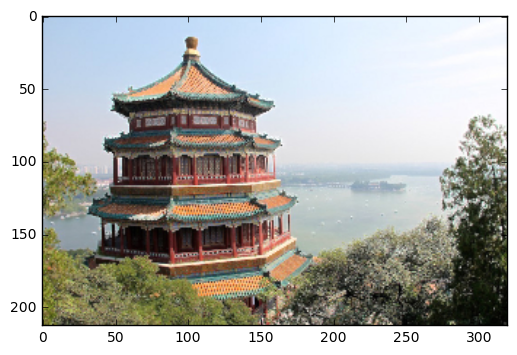

In [31]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict = {X: dataset})
    
plt.imshow(output[0].astype(np.uint8))
plt.show()

- MNIST

In [2]:
import time

time_start=time.time()

import tensorflow as tf
import numpy as np
tf.reset_default_graph()
height = 28
width = 28
channels = 1
n_inputs = height*width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10 

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides=conv1_stride, 
                         padding=conv1_pad, activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides=conv2_stride, 
                         padding=conv2_pad, activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps*7*7])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")
    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("E:/Res/Python/hands on ml/mycode/datasets/data")

n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:mnist.test.images, y:mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
time_end=time.time()
print('totally cost',time_end-time_start)

Extracting E:/Res/Python/hands on ml/mycode/datasets/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:/Res/Python/hands on ml/mycode/datasets/data\train-labels-idx1-ubyte.gz
Extracting E:/Res/Python/hands on ml/mycode/datasets/data\t10k-images-idx3-ubyte.gz
Extracting E:/Res/Python/hands on ml/mycode/datasets/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
0 Train accuracy: 1.0 Test accuracy: 0.98
1 Train accuracy: 0.99 Test accuracy: 0.9845


KeyboardInterrupt: 